<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/%5BClustering%5D_DBSCAN_Derfansyah_Guswiranata_Kurnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perkenalan diri
## Nama : Derfansyah Guswiranata Kurnia
## Identitas dicoding: sgkurni
## email dicoding: weerakurnia@gmail.com

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [1]:
#Inisiasi kaggle (tahap awal)
!pip install kaggle

In [2]:
#inisiasi file json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derfansyahgk","key":"24be196f622b75f71753aee422847c5c"}'}

In [3]:
#Pengunduhan dataset melalui Penyetelan dataset kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#unduh file zip sebagai dataset
!kaggle datasets download -d prasad22/weather-data

Dataset URL: https://www.kaggle.com/datasets/prasad22/weather-data
License(s): CC0-1.0
 92% 39.0M/42.6M [00:00<00:00, 116MB/s]
100% 42.6M/42.6M [00:00<00:00, 121MB/s]


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [5]:
#Perpustakaan dataset dasar
import numpy as np
import pandas as pd
import scipy as sp
#Grafik dasar
import matplotlib.pyplot as plt
import seaborn as sns
#grafik PCA
from sklearn.decomposition import PCA

In [6]:
#persiapan perpustakaan untuk protokol clustering
from sklearn.preprocessing import RobustScaler #DBSCAN++
from sklearn.preprocessing import StandardScaler #untuk PCA
#fitur seleksi di DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
#Tetangga terdekat
from sklearn.neighbors import NearestNeighbors

In [7]:
#pelabelan dengan labelencoder
from sklearn.preprocessing import LabelEncoder as lenc

In [8]:
#hdbscan cepat melalui implementasi fast hdbscan
! pip install fast_hdbscan

In [9]:
#persiapan 'titik sementara' di google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Pelabelan dengan HDBSCAN
! pip install hdbscan
from hdbscan import HDBSCAN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.1 MB/s eta 0:00:00


In [11]:
#Bagian moon
from sklearn.datasets import make_moons
from scipy.spatial import distance

In [12]:
#Bagian serialisasi
import multiprocessing as mp
from multiprocessing import Pool, Manager
import os #untuk os
import time

In [13]:
#inisiasi 'dill' untuk serialisasi
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.6 MB/s eta 0:00:00


In [14]:
#perpustakaan untuk DBSCAN++
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [15]:
#Proses Bagian awal (Buka zip, baca, dan salin)
#Buka zip
!unzip weather-data.zip

Archive:  weather-data.zip
  inflating: weather_data.csv        


In [16]:
#Baca dan salin
dfasl = pd.read_csv('/content/weather_data.csv')
dfkopi = dfasl.copy()

In [17]:
#Inisiasi untuk ubah jenis data di tanggal
dfkopi['Date_Time'] = pd.to_datetime(dfkopi['Date_Time']).copy()
#cek jenis data setelah pengubahan
dfkopi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Location          1000000 non-null  object        
 1   Date_Time         1000000 non-null  datetime64[ns]
 2   Temperature_C     1000000 non-null  float64       
 3   Humidity_pct      1000000 non-null  float64       
 4   Precipitation_mm  1000000 non-null  float64       
 5   Wind_Speed_kmh    1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 45.8+ MB


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

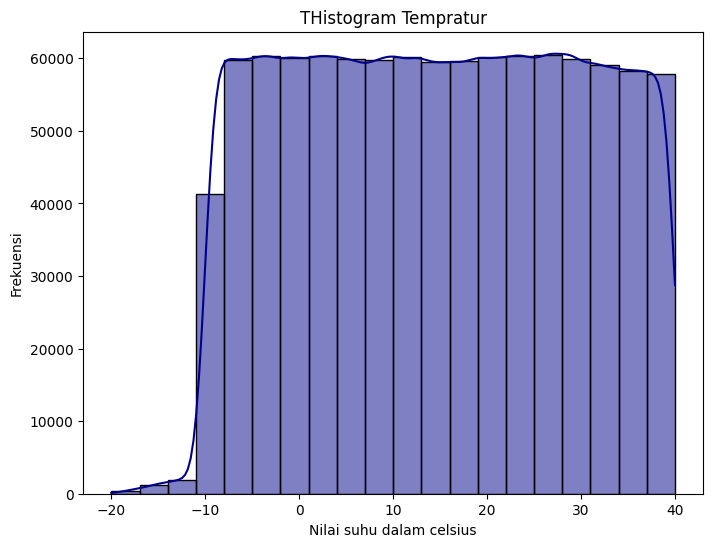

In [18]:
#Histogram suhu
plt.figure(figsize=(8, 6))
sns.histplot(dfkopi['Temperature_C'], bins=20, kde=True, color='darkblue')
plt.title('THistogram Tempratur')
plt.xlabel('Nilai suhu dalam celsius')
plt.ylabel('Frekuensi')
plt.show()

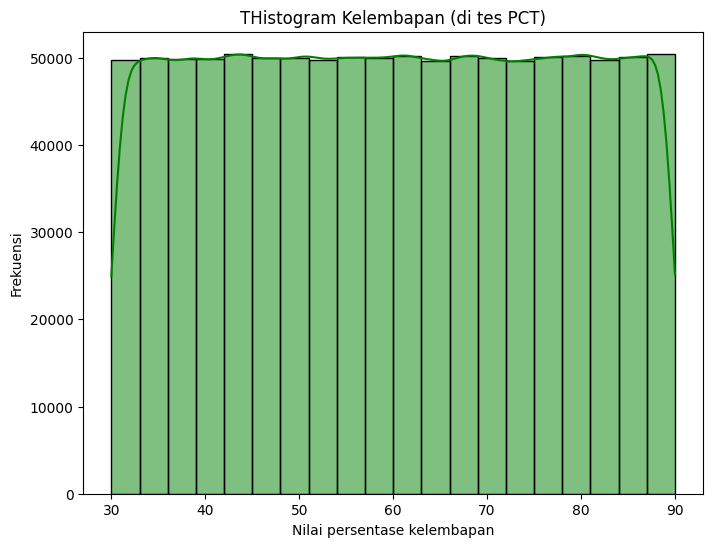

In [19]:
#Histogram kelembapan
plt.figure(figsize=(8, 6))
sns.histplot(dfkopi['Humidity_pct'], bins=20, kde=True, color='green')
plt.title('THistogram Kelembapan (di tes PCT)')
plt.xlabel('Nilai persentase kelembapan')
plt.ylabel('Frekuensi')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [20]:
#Pemeriksaan kolom kosong
tothil = dfkopi.isna().sum() #total data hilanhg
print(tothil)

Location            0
Date_Time           0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64


In [21]:
#inspeksi data kosong
totkos = dfkopi.isnull().sum() #total data kosong
print(totkos)

Location            0
Date_Time           0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64


In [22]:
#Hapus kolom kosong dan duplikat
dfkopi2 = dfkopi.dropna(inplace=True)
dfkopi2 = dfkopi.drop_duplicates()

In [23]:
#cek informasi
dfkopi2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Location          1000000 non-null  object        
 1   Date_Time         1000000 non-null  datetime64[ns]
 2   Temperature_C     1000000 non-null  float64       
 3   Humidity_pct      1000000 non-null  float64       
 4   Precipitation_mm  1000000 non-null  float64       
 5   Wind_Speed_kmh    1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 45.8+ MB


In [24]:
#Persiapan untuk pelabelan (pisah kolom)
numkol = dfkopi2.iloc[:, 2:].copy() #indeks numerik
kolokasi = dfkopi2.iloc[:, 0].copy() #indeks lokasi untuk kategori
koltgl = dfkopi2.iloc[:, 1].copy() #indeks tanggal untuk tanggal

In [25]:
#cek kolom kategori
kolokasi.head(7) #cek format lokasi

,Location
0,San Diego
1,San Diego
2,San Diego
3,Philadelphia
4,San Antonio
5,San Diego
6,San Jose


In [26]:
#lihat hasil tanggal untuk sekuensial
koltgl.head(7) #cek format tanggal

,Date_Time
0,2024-01-14 21:12:46
1,2024-05-17 15:22:10
2,2024-05-11 09:30:59
3,2024-02-26 17:32:39
4,2024-04-29 13:23:51
5,2024-01-21 08:54:56
6,2024-01-13 02:10:54


In [27]:
#cek hasil numerik
numkol.head(7)

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,10.683001,41.195754,4.020119,8.233540
1,8.734140,58.319107,9.111623,27.715161
2,11.632436,38.820175,4.607511,28.732951
3,-8.628976,54.074474,3.183720,26.367303
4,39.808213,72.899908,9.598282,29.898622
5,27.341055,49.023236,9.166543,27.473896
6,1.881883,65.742325,0.221709,1.073112


In [28]:
#Persiapan pergantian nama (cek lokasi)
jnslok = kolokasi.unique().copy()
jnslok

array(['San Diego', 'Philadelphia', 'San Antonio', 'San Jose', 'New York',
       'Houston', 'Dallas', 'Chicago', 'Los Angeles', 'Phoenix'],
      dtype=object)

Ada 10 lokasi

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [29]:
#Inisiasi pelabelan
encoder = lenc()
lokenc = encoder.fit_transform(kolokasi).copy()
#pengubahan ke bentuk df
dflokenc = pd.DataFrame(lokenc, columns=['Lokasi'])
#pembuatan label
dflokenc2 = dflokenc.copy()
#iterasi untuk pemeriksaan
for column in dflokenc2.select_dtypes(include=['object']).columns:
    le = lenc()
    dflokenc2[column] = le.fit_transform(dflokenc2[column])

In [30]:
#Lihat hasil
dflokenc2.head(7)

,Lokasi
0,8
1,8
2,8
3,5
4,7
5,8
6,9


In [31]:
#Persiapan penskalaan untuk DBSCAN++ dan grafik PCA
stdscal = StandardScaler() #Untuk PCA
rbstscal = RobustScaler() #Untuk DBSCAN++
#penskalaan
stdnum = stdscal.fit_transform(numkol) #PCA
rbstnum = rbstscal.fit_transform(numkol) #DBSCAN++

In [32]:
#Pengubahan ke df
dfstdnum = pd.DataFrame(stdnum, columns=numkol.columns) #untuk PCA
dfrbstnum = pd.DataFrame(rbstnum, columns=numkol.columns) #untuk DBSCAN++
#ke cek sampel

In [33]:
#cek sampel
dfstdnum.head(7) #Hasil standar

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,-0.282872,-1.086704,-0.369580,-0.780749
1,-0.417438,-0.098287,1.357527,1.467939
2,-0.217315,-1.223830,-0.170329,1.585418
3,-1.616337,-0.343301,-0.653298,1.312361
4,1.728184,0.743366,1.522608,1.719967
5,0.867344,-0.634876,1.376157,1.440090
6,-0.890577,0.330206,-1.658052,-1.607249


In [34]:
#cek hasil robust
dfrbstnum.head(7) #Hasil robust

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,-0.163794,-0.626694,-0.216528,-0.449962
1,-0.241746,-0.056587,0.795085,0.846737
2,-0.125818,-0.705787,-0.099821,0.914481
3,-0.936247,-0.197908,-0.382709,0.757023
4,1.001174,0.428868,0.891777,0.992068
5,0.502505,-0.366085,0.805997,0.830678
6,-0.515827,0.190563,-0.971221,-0.926561


## Tahapan evaluasi melalui DBSCAN++

In [35]:
#Penyatuan kembali df untuk eksekusi
dfkomb = pd.concat([koltgl, dflokenc2, dfrbstnum], axis=1, sort=True,copy=True) #Keamanan
dfpcakomb = pd.concat([koltgl, dflokenc2, dfstdnum], axis=1, sort=True,copy=True) #Keamanan
#cek sampel
dfkomb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Date_Time         1000000 non-null  datetime64[ns]
 1   Lokasi            1000000 non-null  int64         
 2   Temperature_C     1000000 non-null  float64       
 3   Humidity_pct      1000000 non-null  float64       
 4   Precipitation_mm  1000000 non-null  float64       
 5   Wind_Speed_kmh    1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 45.8 MB


In [36]:
#cek kolom
print(type(dfkomb))

<class 'pandas.core.frame.DataFrame'>


In [37]:
#penghapusan len
del lenc

In [38]:
#Deklarasi berat
berat = dfkomb['Lokasi'].value_counts(normalize=True)

# Pemetaan dfkomb
dfkomb['berat'] = dfkomb['Lokasi'].map(berat)

# Now, you can use the 'berat' column as weights for sampling
sampkomb = int(len(dfkomb) * 0.025)  # Adjust for 5% if needed
dfsampkomb = dfkomb.sample(n=sampkomb, weights='berat', random_state=42).copy()

In [39]:
#cek dfsampel setelah pemberatan
dfsampkomb.head(7)

,Date_Time,Lokasi,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,berat
374539,2024-01-05 04:32:12,1,-0.830171,0.084567,0.351777,-0.474705,0.099936
950713,2024-04-08 21:19:00,2,0.082419,0.559269,0.654748,0.229871,0.100076
731993,2024-05-11 04:48:18,0,0.083336,-0.301075,0.937340,-0.032888,0.100164
598657,2024-05-03 08:53:42,3,-0.212684,0.981805,-0.128374,0.421593,0.099922
156018,2024-02-03 12:57:12,8,0.392890,0.386854,-0.314508,-0.316925,0.099774
155993,2024-02-15 01:54:25,2,-0.049804,-0.749294,-0.348018,-0.510644,0.100076
58083,2024-03-03 05:11:59,5,-0.013293,-0.250803,0.512384,0.754274,0.100122


In [40]:
#cek df utuh setelah pemberatan
dfkomb.head(7)

,Date_Time,Lokasi,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,berat
0,2024-01-14 21:12:46,8,-0.163794,-0.626694,-0.216528,-0.449962,0.099774
1,2024-05-17 15:22:10,8,-0.241746,-0.056587,0.795085,0.846737,0.099774
2,2024-05-11 09:30:59,8,-0.125818,-0.705787,-0.099821,0.914481,0.099774
3,2024-02-26 17:32:39,5,-0.936247,-0.197908,-0.382709,0.757023,0.100122
4,2024-04-29 13:23:51,7,1.001174,0.428868,0.891777,0.992068,0.099962
5,2024-01-21 08:54:56,8,0.502505,-0.366085,0.805997,0.830678,0.099774
6,2024-01-13 02:10:54,9,-0.515827,0.190563,-0.971221,-0.926561,0.099863


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [44]:
#deklarasi daftar pencarian
dfpnormal = [65,70,75,80,85,90,95,100,105,110,115] #normal
dfpsf = [50,55,60,65,70,75,80,85,90,95] #dengan sf

In [45]:
#Persiapan untuk pencarian nilai epsilon
def find_optimal_eps(data, min_pts):
    nbrs = NearestNeighbors(n_neighbors=min_pts).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, min_pts-1], axis=0)  # Get distance to min_pts-th neighbor
    plt.plot(distances)
    plt.title('Grafik penetuan epsilon')
    plt.xlabel('Poin dari jarak tetangga')
    plt.ylabel('Jarak ke tetangga terdekat urutan ke {}-th '.format(min_pts))
    plt.show()
    #ke eksekusi penentuan

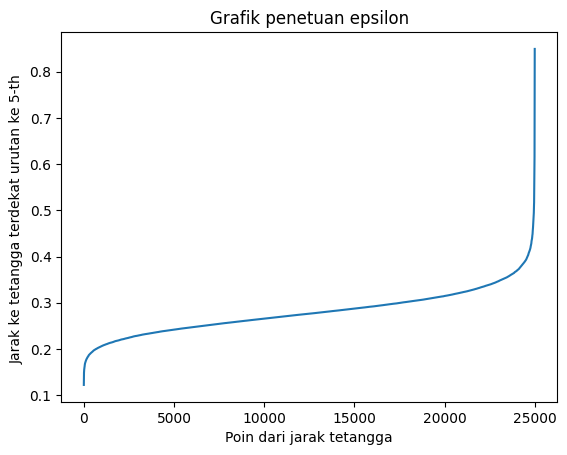

In [46]:
#cek hasil episilon
hslsamp = find_optimal_eps(dfsampkomb.drop(columns=['Date_Time']).copy(), min_pts=5)

In [43]:
#Tahap multi proses untuk penentuan nilai optimal (deklarasi hasil terbaik)
def run_dbscan(params):
    eps, min_samples = params
    data_copy = dfsampkomb.drop(columns=['Date_Time']).copy()

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_copy)

    if len(set(labels)) > 1:  # Avoid 'noise'
        score = silhouette_score(data_copy, labels)
        return (round(eps, 3), min_samples, round(score, 3))

    return (round(eps, 3), min_samples, -1)

# Define epsilon and minimum samples ranges
eps_values = np.arange(0.47, 1.940, 0.05)
min_samples_values = dfpnormal

# Create parameter list for all combinations of eps and min_samples
params_list = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

# Initialize variables to track optimal score and parameters
optimal_score_found = False
optimal_score_value = (None, None, -1)  # (eps, min_samples, score)

# Execute the function for each parameter set
results = []
for params in params_list:
    result = run_dbscan(params)
    results.append(result)

    eps, min_samples, score = result

    if score >= 0.7:  # Optimal threshold
        optimal_score_found = True
        optimal_score_value = (eps, min_samples, score)
        break  # Hentikan jika sudah optimal

    elif score >= 0.55:
        if optimal_score_value[2] < score:
            optimal_score_value = (eps, min_samples, score)

# Saring sesuai kriteria
filtered_results = [(eps, min_samples, score) for eps, min_samples, score in results if score >= 0.55]

# Identify the best parameters based on silhouette score
optimal_params = max(filtered_results, key=lambda x: x[2], default=None)

if optimal_params:
    print(f"Nilai Epsilon: {optimal_params[0]}, Indeks Min Points: {optimal_params[1]}, Nilai Siluet Optimal: {optimal_params[2]}")
else:
    print("Nilai sesuai tidak ditemukan.")
  #ke persiapan modifikasi

Nilai sesuai tidak ditemukan.


In [177]:
#Identifikasi parameter optimal (kondisi normal)
if optimal_params:
    epsopt = optimal_params[0]
    sampminopt = optimal_params[1]

In [ ]:
#inspeksi nilai setelah jasi
print(epsopt)
print(sampminopt)

In [ ]:
#eksekusi asli dala kondisi normal
dbscan = DBSCAN(eps=epsopt, min_samples=sampminopt) #ak harap bagis
hsllabel = dbscan.fit_predict(dfsampkomb.drop(columns=['Date_Time']).copy()).copy

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [180]:
#Tahap 1 (nilai epsilon dalam kondisi sf)
def find_optimal_eps(data, min_pts):
    nbrs = NearestNeighbors(n_neighbors=min_pts).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, min_pts-1], axis=0)  # Jarak terdekat
    plt.plot(distances)
    plt.title('Grafik penetuan epsilon')
    plt.xlabel('Poin dari jarak tetangga')
    plt.ylabel('Jarak ke tetangga terdekat urutan ke {}-th '.format(min_pts))
    plt.show()
#ke inisiasi seleksi fitur

In [184]:
#seleksi fitur (deklarasi nilai)
def select_features(data, k):
    """Inspeksi nilai k melalui ANOVA"""
    selector = SelectKBest(score_func=f_classif, k=k)
    selected_data = selector.fit_transform(data, np.zeros(data.shape[0]))
    return selected_data
#ke modifikasi sf untuk eksekusi fungsi dalam sf

In [ ]:
#eksekusi dbscan melalui seleksi fitur
def run_dbscan_sf(params):
    eps, min_samples, k_features, optimal_score_found_ref, optimal_score_value_ref = params
    data_copy = dfsampkomb.drop(columns=['Date_Time']).copy()

    # Feature selection step (assuming select_features is defined elsewhere)
    selected_data = select_features(data_copy, k_features)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(selected_data)

    if len(set(labels)) > 1:  # Avoid 'noise' value
        score = silhouette_score(selected_data, labels)

        # Inspeksi nilai jika nilai melewati optimal
        if score >= 0.7 and not optimal_score_found_ref.value:
            optimal_score_found_ref.value = True
            return (round(eps, 3), min_samples, round(score, 3), k_features)

        # Update reference if current score is better
        if optimal_score_value_ref[2] < score:
            optimal_score_value_ref[0] = round(eps, 3)
            optimal_score_value_ref[1] = min_samples
            optimal_score_value_ref[2] = round(score, 3)

    return (round(eps, 3), min_samples, -1, k_features)

# Define function with range values
eps_values = np.arange(0.45, 2.10, 0.05)  # Minimal epsilon values
min_samples_values = dfpsf  # KisaranNilai minimal

# Results storage for k features
results_all_features = []

# Create a manager for shared variables
manager = Manager()
optimal_score_found = manager.Value('b', False)  # Shared boolean for optimal score found
optimal_score_value = manager.list([None, None, -1])  # Shared list for optimal values

# Iterate over k values
for k_features in range(1, 21):  # Tuning values
    params_list = [(eps, min_samples, k_features, optimal_score_found, optimal_score_value)
                   for eps in eps_values for min_samples in min_samples_values]

    # Execute DBSCAN using multiprocessing Pool
    with Pool(processes=4) as pool:  # Adjust number of processes as needed
        results = pool.map(run_dbscan_sf, params_list)

    # Filter results based on silhouette score criteria
    filtered_results = [(eps, min_samples, score, k)
                        for eps, min_samples, score, k in results if score >= 0.55]

    # Store results with feature selection
    results_all_features.append((k_features, filtered_results))

# Feature analysis stage
for k_features, filtered_results in results_all_features:
    if filtered_results:
        optimal_params = max(filtered_results, key=lambda x: x[2], default=None)
        if optimal_params:
            print(f"Untuk {k_features} fitur: Nilai Epsilon: {optimal_params[0]}, Indeks Min Points: {optimal_params[1]}, Nilai Siluet: {optimal_params[2]}")
            if optimal_params[2] >= 0.7:
                print("Optimal!")
            elif optimal_params[2] >= 0.55:
                print("Minimal memenuhi persyaratan.")
    else:
        print(f"Untuk {k_features} fitur: Tidak ada hasil yang memenuhi.")
#ke eksekusi dengan seleksi fitur

In [ ]:
# Eksekusi DBSCAN dengan seleksi fitur pada jumlah fitur yang sesuai (gunakan nilai optimal terakhir ditemukan)
if 'optimal_params' in locals() and optimal_params is not None:
    epsopt = optimal_params[0]
    sampminopt = optimal_params[1]
  #ke eksekusi tahap akhir

In [ ]:
# Eksekusi tahap akhir untuk seleksi fitur dengan jumlah fitur yang sesuai
final_selected_data = select_features(dfsampkomb.drop(columns=['Date_Time']).copy(), optimal_params[3])
#ke eksekusi dbscan dengan seleksi fitur

In [ ]:
#eksekusi akhir
dbscan_final = DBSCAN(eps=epsopt, min_samples=sampminopt)
hsllabel = dbscan_final.fit_predict(final_selected_data).copy()

In [183]:
#hapuskan aktivasi ray
ray.shutdown()

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Tahap 1 PCA normal (variasi hasil)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dfpcakomb.drop(columns=['Date_Time']).copy())

In [ ]:
#penyetaln dataset untuk PCA
pca_df = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = hsllabel  # Penambahan label

In [ ]:
#Perlihatkan hasil kondisi normal
plt.figure(figsize=(12, 7))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.title('Inspeksi Grafik PCA')
plt.xlabel('Konsep Prinsip 1')
plt.ylabel('Konsep Prinsip 1')
plt.colorbar(scatter, label='Label Kluster')
plt.grid()
plt.show()

In [ ]:
#PCA dalam kondisi seleksi fitur (standardisasi dengan standardscaler)
stdscal = StandardScaler()
stdsf = stdscal.fit_transform(final_selected_data)
#Penerapan PCA
pca = PCA(n_components=2)  # Nilai bisa distel
komponen = pca.fit_transform(stdsf)
#ke konversi ke bentuk

In [ ]:
#konversi df
pca_df = pd.DataFrame(data=komponen, columns=['PC1', 'PC2'])
#Nilai rasio variasi
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')
#ke ilustrasi

In [ ]:
#ilustrasi dengan seleksi fitur
plt.figure(figsize=(12, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.